## How to sample points from nonrectangular domains?

* Recall the previous circle problem. We needed a square that enclosed the circle. Which of the two situations will be more efficient?

<img src="https://ignite.byu.edu/che541/lectures/figs/l38f01.png" width="400">



* Clearly the case on the right is better. We will have fewer wasted darts in the smaller blue square area on the right. 


* Similarly, the case on the right in the figure below will be more accurate.
<img src="https://ignite.byu.edu/che541/lectures/figs/l38f02.png" width="500">

* **But how do we sample uniformly under the half circle the right figure?**
    * For a rectangle, we just used a uniform random number generator to get random x and y points.
    * There are routines for generating random points that fit some given distribution, such as normally distributed random points. 

### Approach

* Let the curve we want to generate points on be $g(x)$. 
* Let $G(x)=\int_a^xg(x)dx,$ where $a$ is the lower bound of integration.
* We sample uniformly on $G$ and invert to find the corresponding $x=G^{-1}$.
* The resulting $x$ locations will be distributed consistent with $g(x)$.
* To get the $y$ location of a point corresponding to $x$, we sample a random number uniformly on $[0,\,g(x)]$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import erf
from scipy.optimize import fsolve
from scipy.integrate import quad

plt.rc('font', size=14)

def make_plot():

    μ = 2
    σ = 0.5
    x = np.linspace(0,4,100)
    g = 1/np.sqrt(2*np.pi*σ**2)*np.exp(-1/2/σ**2*(x-μ)**2)
    G = 0.5*(1+erf(1/σ/np.sqrt(2)*(x-μ))) 
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.plot(x,g)
    ax1.set_xlabel('x'); ax1.set_ylabel('g(x)')
    ax1.set_xlim([0,4]); ax1.set_ylim([-0.1,1])
    ax2.plot(x,G)
    ax2.set_xlabel('x'); ax2.set_ylabel('G(x)')
    ax2.set_xlim([0,4]); ax2.set_ylim([-0.1,1])
    
    def Ginv(xFind, Gwant):
        return 0.5*(1+erf(1/σ/np.sqrt(2)*(xFind-μ))) - Gwant
    for yy in np.linspace(0.01,0.99,15):
        xx = fsolve(Ginv, μ, args=yy)[0]
        ax2.arrow(4, yy, xx-4+0.1, 0,      head_width=0.02, head_length=0.1,  fc='gray', ec='gray', linestyle='dashed')
        ax2.arrow(xx, yy, 0, -yy+0.05-0.1, head_width=0.05, head_length=0.05, fc='gray', ec='gray')
    
    plt.tight_layout()

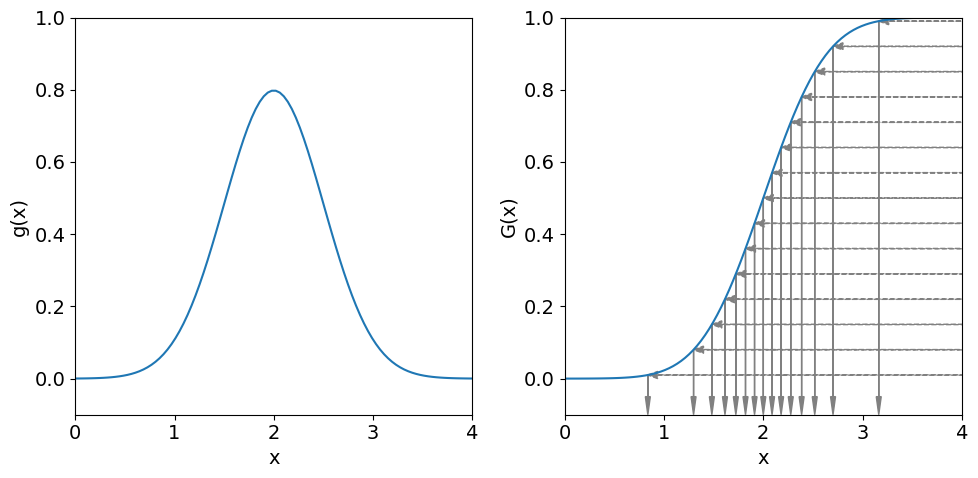

In [2]:
make_plot()

#### Example: let $g(x)$ be a normal distribution

In [3]:
n    = 2000                        # number of points

#---------- Define g(x)

μ    = 2                           
σ    = 0.5
maxG = 1.0
def g(x):
    return 1/np.sqrt(2*np.pi*σ**2)*np.exp(-1/2/σ**2*(x-μ)**2)

#---------- get g(x) distributed random x points

rG = np.random.rand(n)*maxG      # uniform samples on G
rx = np.empty(n)                 # corresponding x locations found next

def Ginv(xFind, Ggiven):          # inverse function: G --> x
    return 0.5*(1+erf(1/σ/np.sqrt(2)*(xFind-μ))) - Ggiven
for i, rGi in enumerate(rG):
    rx[i] = fsolve(Ginv, μ, args=rGi)
    
#---------- get y points below g(x)
    
ry = np.empty(n)
for i in range(n):
    ry[i] = np.random.rand()*g(rx[i])

#---------- plot results

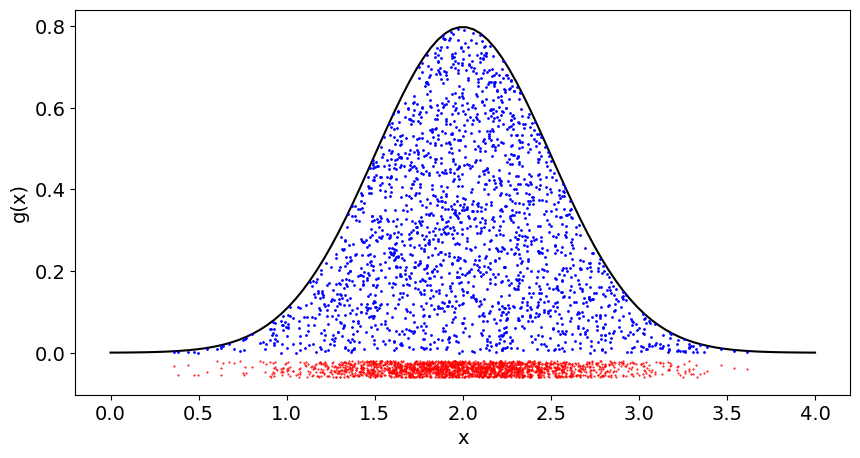

In [4]:
x = np.linspace(0,2*μ,100)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(x,g(x), 'k-');
ax.plot(rx, ry, 'b.', markersize=2);
ax.plot(rx, np.random.rand(len(rx))*0.04-0.02-0.04, '.', markersize=1.0, color='red')
ax.set_xlabel('x');
ax.set_ylabel('g(x)');
    

### Sampling nonuniformly distributed random numbers
* Most random number generators provide uniformly distributed random numbers on the domain $[0,\,1]$.
* In the previous example, we saw how to sample random points that are normally distributed. 
    * Specifically, the selection of $x$ points will be normally distributed.
    * This means that there are more $x$ points near $\mu$ where the peak is, than on the tails.
    * In the above example, we also found corresponding random $y$ points.
    * **However, in this section, we are only interested in the nonuniformly distributed $x$ points.**
    * For example, plotting a histogram of the ```rx``` points above gives:

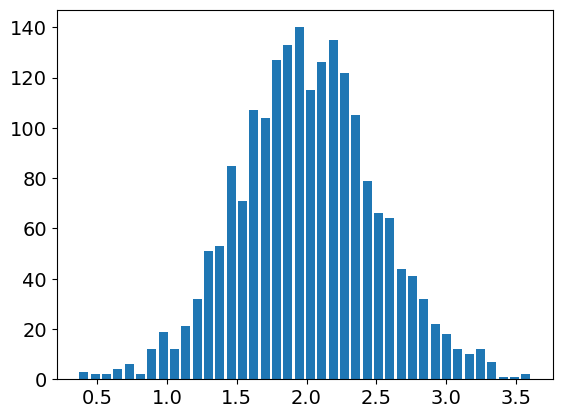

In [5]:
plt.hist(rx, 40, rwidth=0.8);

* The previous method is difficult if the integration of $g(x)$ is complex or expensive and/or if the subsequent inversion of $G(x)$ is complex or expensive. 
* Another method for sampling uniformly distributed points from a nonrectangular region is similar to the MC integration problem.
* However, we are not doing integration here, only showing another method for sampling from a nonuniform distribution. 
* This method does not require integration of $g(x)$ or inversion of $G(x)$. 
* We draw a bounding curve $F(x)$ that is easy to integrate and invert. This could be a rectangle.
    * $F(x)$ is everywhere greater than $g(x)$.
* Then we draw an $r_x$ point from from the bounding curve, as previously described (using G(x)).
* Now we accept the sample point with probability $g(r_x)/F(r_x)$.
    * This is done by sampling a random number between 0 and 1. If the random number is less than $g(r_x)/F(r_x)$, then we accept the point, otherwise we reject it.
* This approach is called the **rejection method**.



#### Example

* Sample random normally distributed variables using the rejection method.

In [17]:
def make_plot2():
    n    = 8000                 # random numbers to try (not all kept)
    μ    = 2                           
    σ    = 0.5
    def g(x):
        return 1/np.sqrt(2*np.pi*σ**2)*np.exp(-1/2/σ**2*(x-μ)**2)
    def F(x):                   # bounding function, here a simple uniform profile
        return 1
    
    #-----------------
    
    nkeep = 0                   # total number kept: incremented below
    rx_all = np.empty(0)        # storage for all points: expanded below
    
    for i in range(n):
        rx = np.random.rand()*2*μ
        Paccept = g(rx)/F(rx)
        r  = np.random.rand()        
        if r<Paccept:
            rx_all=np.append(rx_all, rx)
            nkeep += 1
            
    #-----------------
    
    plt.hist(rx_all, 40, rwidth=0.8);
    plt.xlim([0,4])
    

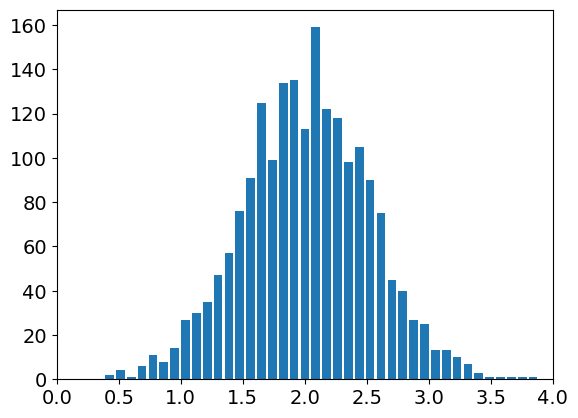

In [24]:
make_plot2()

## Example-Poisson Process

* Poisson Processes are extremely important in probability theory.
* Used to model random processes in time and space
    * Raindrop spacing, radioactive decay, eddies in turbulence, etc.
    


### Raindrops

* Suppose it's ~~raining~~ snowing ~~lightly~~ heavily and you listen to the time spacing of droplets. 
* There will be some average rate.
* But sometimes ~~drops~~ flakes will be very close together, and sometimes far apart.


#### Question: what is the distribution of the spacing between events and can we model this?

* **Find the PDF of intervals between events; that is $p(\Delta t_e)$**.
* Assume events occur randomly in time with a mean event rate $\lambda$ (=) $s^{-1}$. That is, $\lambda$ drops per second, on average.
* Assume events are statistically independent of each other.
* The probability of getting an event in some interval $dt$ is $\lambda dt$, or $dt/T$, where $T=1/\lambda$ is the mean time between events.
* Consider the interval $(t_0,\,t_0+\Delta t_e)$, with some sub-intervals:

```
|  1     2     3     4  |
|-----|-----|-----|-----|
| dt    dt    dt    dt  |
```
$\phantom{xxx}t_0\phantom{xxxxxxxxxxxxxxxxxx}t_0+\Delta t_e$



* The probability of **not** getting an event in sub-interval 1 is $1-\lambda dt$. 
* The probability of not getting an event in sub-interval 1 **and** sub-interval 2 **and** $\ldots$ sub-interval 4 is 

$$(1-\lambda dt)^4,$$

* or, for $n$ sub-intervals

$$(1-\lambda dt)^n \rightarrow (1-\lambda dt)^{\Delta t_e/dt}$$




* Now, let $dt\rightarrow 0$.
* $P(t_{\text{next event}}>\Delta t_e) = \lim_{dt\rightarrow 0}(1-\lambda dt)^{\Delta t_e/dt}$.
* Now, at $dt=0$ we have $1^{\infty}$. Work on this:

\begin{align}
\ln P &= \ln \left[\lim_{dt\rightarrow 0}(1-\lambda dt)^{\Delta t_e/dt}\right], \\
      &= \lim_{dt\rightarrow 0}\ln\left[(1-\lambda dt)^{\Delta t_e/dt}\right],\\
      &= \lim_{dt\rightarrow 0}\frac{\Delta t_e}{dt}\ln\left[1-\lambda dt\right].\\
\end{align}




* Now, at $dt=0$ we have $0/0$, so use L'Hopital's Rule.

$$\ln P = \lim_{dt\rightarrow 0}\frac{-\lambda \Delta t_e}{(1-\lambda dt)} = -\lambda \Delta t_e.$$

Hence, 
$$P(t_{\text{next event}}>\Delta t_e)  = e^{-\lambda \Delta t_e}.$$
Or,
$$P(t_{\text{next event}}<\Delta t_e)  = 1- e^{-\lambda \Delta t_e}.$$


* This is a cumulative distribution function. 
* Differentiate it to get the probability density function:

<font color="blue">
$$p(\Delta t_e) = \lambda e^{-\lambda \Delta t_e}.$$
</font>

* This is an exponential distribution.
* So, to generate exponentially-distributed events, randomly sample $\Delta t_e$ values from this distribution.
    * As above, draw uniform samples of $P(\Delta t_e)$ (the cumulative distribution function) on $[0,\,1]$. Invert this function to get $\Delta t_e$.
    * The inversion, is just solving the expression for $P(\Delta t_e)$ for $\Delta t_e$, where $P$ values are taken as random numbers between 0 and 1:
    
    $$\Delta t_e = -\frac{\ln(1-P)}{\lambda}.$$

In [8]:
def make_plot3():
    λ = 1                   
    n = 2000
    rP = np.random.rand(n)
    Δt_e = -np.log(1-rP)/λ
    
    x = np.linspace(0,8,1000)
    y = λ*np.exp(-λ*x)
    
    times = np.cumsum(Δt_e[:40])
    
    plt.rc('font', size=14);
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    
    ax1.hist(Δt_e, 80, density=True, rwidth=0.8);
    ax1.plot(x,y, linewidth=3);
    ax1.set_xlabel(r'$\Delta t_e$');
    ax1.set_ylabel(r'$p(\Delta t_e)$');
    ax1.set_xlim([0,5])
    
    ax2.plot(times, np.zeros(len(times)), '.', markersize=5)
    for t in times:
        ax2.axvline(x=t, ymin=0.45, ymax=0.55, linewidth=1, color='gray')
    ax2.set_xlabel('time')
    ax2.set_ylim([-1,1])
    
    plt.tight_layout()

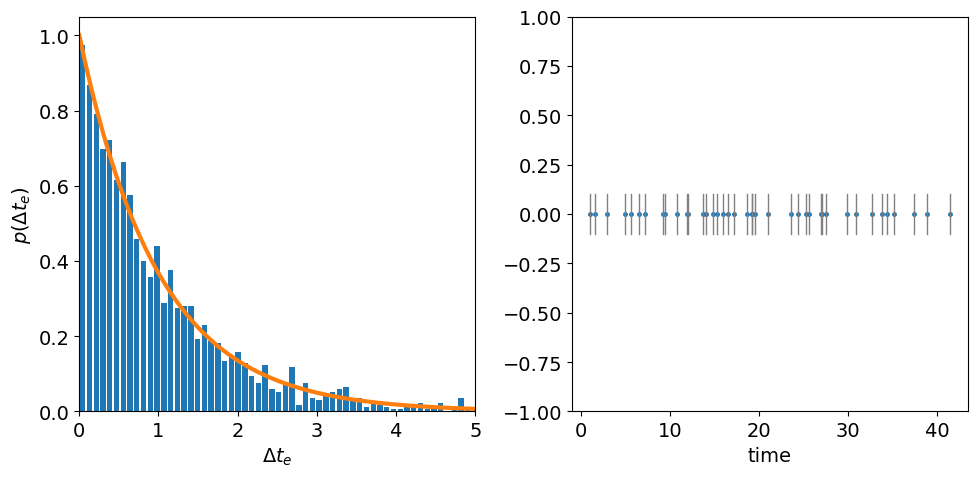

In [9]:
make_plot3()